# Import

In [6]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme()


In [7]:
fires= pd.read_csv('fires.csv')
fires

# Création d'un dataframe pour la modélisation. On enlève à notre dataset de départ (fires) les variables qu'on juge inutiles pour n'importe quelle modélisation. 
fires_model = fires
fires_model.info()

C:\Users\Enedis\AppData\Local\Temp\ipykernel_14556\3770234963.py:1: DtypeWarning: Columns (8,10,11,12,13,14,15,16,17,18,35,37,39,42) have mixed types. Specify dtype option on import or set low_memory=False.
  fires= pd.read_csv('fires.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1880465 entries, 0 to 1880464
Data columns (total 48 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   OBJECTID                    int64  
 1   FOD_ID                      int64  
 2   FPA_ID                      object 
 3   SOURCE_SYSTEM_TYPE          object 
 4   SOURCE_SYSTEM               object 
 5   NWCG_REPORTING_AGENCY       object 
 6   NWCG_REPORTING_UNIT_ID      object 
 7   NWCG_REPORTING_UNIT_NAME    object 
 8   SOURCE_REPORTING_UNIT       object 
 9   SOURCE_REPORTING_UNIT_NAME  object 
 10  LOCAL_FIRE_REPORT_ID        object 
 11  LOCAL_INCIDENT_ID           object 
 12  FIRE_CODE                   object 
 13  FIRE_NAME                   object 
 14  ICS_209_INCIDENT_NUMBER     object 
 15  ICS_209_NAME                object 
 16  MTBS_ID                     object 
 17  MTBS_FIRE_NAME              object 
 18  COMPLEX_NAME                object 
 19  FIRE_YEAR            

# Constitution du dataset

Nous privilégions la variable STAT_CAUSE_DESCR à la variable STAT_CAUSE_CODE car nous regrouperons des causes dans des catégories qui seront ensuite encodées.

In [8]:
# Vérification des données nulles
print(fires_model.isna().sum())


# Nous supprimons les ID, les colonnes avec beaucoup de valeurs manquantes, les colonnes DIFF_YEAR, CONT_DATE_COR et FIRE_SIZE_CLASS_TEST qui ont été créées pour vérifier 
# la conformité des données. Nous supprimons également les colonnes inutiles et les variables avec beaucoup de valeurs aberrantes telle que DURATION.
# Nous allons conserver les variables suivantes (on remplace MONTH par SPLIT_MONTH):
fires_model = fires[['STAT_CAUSE_DESCR','FIRE_SIZE_CLASS', 'STATE', 'DAY', 'FIRE_YEAR', 'DISCOVERY_DAY', 'LATITUDE', 'LONGITUDE', 'FIRE_SIZE', 'SPLIT_MONTH', 'SPLIT_DAY']]

# Vérification des NaN
print(fires_model.isna().sum())

#Dimension du dataframe
print(fires_model.shape) #(1880465, 11)

OBJECTID                            0
FOD_ID                              0
FPA_ID                              0
SOURCE_SYSTEM_TYPE                  0
SOURCE_SYSTEM                       0
NWCG_REPORTING_AGENCY               0
NWCG_REPORTING_UNIT_ID              0
NWCG_REPORTING_UNIT_NAME            0
SOURCE_REPORTING_UNIT               0
SOURCE_REPORTING_UNIT_NAME          0
LOCAL_FIRE_REPORT_ID          1459286
LOCAL_INCIDENT_ID              820821
FIRE_CODE                     1555741
FIRE_NAME                      960479
ICS_209_INCIDENT_NUMBER       1854748
ICS_209_NAME                  1854748
MTBS_ID                       1869462
MTBS_FIRE_NAME                1869462
COMPLEX_NAME                  1875282
FIRE_YEAR                           0
DISCOVERY_DATE                      0
DISCOVERY_DAY                       0
DISCOVERY_TIME                 882638
STAT_CAUSE_CODE                     0
STAT_CAUSE_DESCR                    0
CONT_DATE                      891531
CONT_DAY    

In [9]:
# ajout d'une colonne regroupant Etat-année-mois pour pouvoir insérer les données météorologiques
fires_model['FIRE_YEAR'] = fires_model['FIRE_YEAR'].astype('str')
fires_model['SPLIT_MONTH'] = fires_model['SPLIT_MONTH'].astype('str')
fires_model['concat_state_year_month'] = fires_model['STATE'] + '-' + fires_model['FIRE_YEAR'] + '-' + fires_model['SPLIT_MONTH']
fires_model

C:\Users\Enedis\AppData\Local\Temp\ipykernel_14556\4254704411.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fires_model['FIRE_YEAR'] = fires_model['FIRE_YEAR'].astype('str')
C:\Users\Enedis\AppData\Local\Temp\ipykernel_14556\4254704411.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fires_model['SPLIT_MONTH'] = fires_model['SPLIT_MONTH'].astype('str')
C:\Users\Enedis\AppData\Local\Temp\ipykernel_14556\4254704411.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

,STAT_CAUSE_DESCR,FIRE_SIZE_CLASS,STATE,DAY,FIRE_YEAR,DISCOVERY_DAY,LATITUDE,LONGITUDE,FIRE_SIZE,SPLIT_MONTH,SPLIT_DAY,concat_state_year_month
0,Miscellaneous,A,CA,Wednesday,2005,33,40.036944,-121.005833,0.10,2,2,CA-2005-2
1,Lightning,A,CA,Wednesday,2004,133,38.933056,-120.404444,0.25,5,12,CA-2004-5
2,Debris Burning,A,CA,Monday,2004,152,38.984167,-120.735556,0.10,5,31,CA-2004-5
3,Lightning,A,CA,Monday,2004,180,38.559167,-119.913333,0.10,6,28,CA-2004-6
4,Lightning,A,CA,Monday,2004,180,38.559167,-119.933056,0.10,6,28,CA-2004-6
...,...,...,...,...,...,...,...,...,...,...,...,...
1880460,Missing/Undefined,A,CA,Saturday,2015,269,40.481637,-122.389375,0.01,9,26,CA-2015-9
1880461,Miscellaneous,A,CA,Monday,2015,278,37.617619,-120.938570,0.20,10,5,CA-2015-10
1880462,Missing/Undefined,A,CA,Saturday,2015,122,37.617619,-120.938570,0.10,5,2,CA-2015-5
1880463,Missing/Undefined,B,CA,Wednesday,2015,287,37.672235,-120.898356,2.00,10,14,CA-2015-10


In [10]:
# Chargement du fichier avec les données météorologiques
meteo = pd.read_csv('weather_month.csv',sep=',')
meteo = meteo.drop('Unnamed: 0',axis=1)
meteo

,state_code_year,month,WET_DRY_SPELL,PRECIPITATION,TEMPERATURE,CLIMAT,STATE_YEAR_MONTH
0,AK-1992,1,-99.99,3.59,6.5,continental humide ete frais,AK-1992-1
1,AK-1992,2,-99.99,2.69,0.3,continental humide ete frais,AK-1992-2
2,AK-1992,3,-99.99,3.14,12.8,continental humide ete frais,AK-1992-3
3,AK-1992,4,-99.99,1.43,22.6,continental humide ete frais,AK-1992-4
4,AK-1992,5,-99.99,2.27,33.9,continental humide ete frais,AK-1992-5
...,...,...,...,...,...,...,...
14107,WY-2015,8,0.04,0.91,64.3,steppe,WY-2015-8
14108,WY-2015,9,-0.69,0.64,59.4,steppe,WY-2015-9
14109,WY-2015,10,-1.03,1.11,48.7,steppe,WY-2015-10
14110,WY-2015,11,-0.92,1.09,29.2,steppe,WY-2015-11


In [11]:
# Intégration du climat, température moyenne, précipitation moyenne, et indice de sécheresse et humidité moyens
fires_model.insert(8,'CLIMAT',fires_model['concat_state_year_month'].map(meteo.set_index('STATE_YEAR_MONTH')['CLIMAT']))
fires_model.insert(8,'TEMPERATURE',fires_model['concat_state_year_month'].map(meteo.set_index('STATE_YEAR_MONTH')['TEMPERATURE']))
fires_model.insert(9,'PRECIPITATION',fires_model['concat_state_year_month'].map(meteo.set_index('STATE_YEAR_MONTH')['PRECIPITATION']))
fires_model.insert(10,'WET_DRY_SPELL',fires_model['concat_state_year_month'].map(meteo.set_index('STATE_YEAR_MONTH')['WET_DRY_SPELL']))

fires_model

,STAT_CAUSE_DESCR,FIRE_SIZE_CLASS,STATE,DAY,FIRE_YEAR,DISCOVERY_DAY,LATITUDE,LONGITUDE,TEMPERATURE,PRECIPITATION,WET_DRY_SPELL,CLIMAT,FIRE_SIZE,SPLIT_MONTH,SPLIT_DAY,concat_state_year_month
0,Miscellaneous,A,CA,Wednesday,2005,33,40.036944,-121.005833,47.1,4.03,2.28,mediteraneen,0.10,2,2,CA-2005-2
1,Lightning,A,CA,Wednesday,2004,133,38.933056,-120.404444,63.2,0.45,-2.15,mediteraneen,0.25,5,12,CA-2004-5
2,Debris Burning,A,CA,Monday,2004,152,38.984167,-120.735556,63.2,0.45,-2.15,mediteraneen,0.10,5,31,CA-2004-5
3,Lightning,A,CA,Monday,2004,180,38.559167,-119.913333,70.4,0.08,-2.80,mediteraneen,0.10,6,28,CA-2004-6
4,Lightning,A,CA,Monday,2004,180,38.559167,-119.933056,70.4,0.08,-2.80,mediteraneen,0.10,6,28,CA-2004-6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880460,Missing/Undefined,A,CA,Saturday,2015,269,40.481637,-122.389375,72.1,0.33,-4.48,mediteraneen,0.01,9,26,CA-2015-9
1880461,Miscellaneous,A,CA,Monday,2015,278,37.617619,-120.938570,65.0,0.90,-4.48,mediteraneen,0.20,10,5,CA-2015-10
1880462,Missing/Undefined,A,CA,Saturday,2015,122,37.617619,-120.938570,60.8,0.93,-5.11,mediteraneen,0.10,5,2,CA-2015-5
1880463,Missing/Undefined,B,CA,Wednesday,2015,287,37.672235,-120.898356,65.0,0.90,-4.48,mediteraneen,2.00,10,14,CA-2015-10


# Preprocessing

In [12]:
# Présence de NaN ?
fires_model.isna().sum()

STAT_CAUSE_DESCR               0
FIRE_SIZE_CLASS                0
STATE                          0
DAY                            0
FIRE_YEAR                      0
DISCOVERY_DAY                  0
LATITUDE                       0
LONGITUDE                      0
TEMPERATURE                32042
PRECIPITATION              32042
WET_DRY_SPELL              32042
CLIMAT                     32042
FIRE_SIZE                      0
SPLIT_MONTH                    0
SPLIT_DAY                      0
concat_state_year_month        0
dtype: int64

In [13]:
# Suppression des états qui possèdent des NaN => il s'agit des 3 pays en dehors du territoire physique des Etats-Unis ainsi que d'un département qui ne correspond pas à un état finalement => pas intéressant pour notre analyse
fires_model = fires_model.drop(fires_model[(fires_model['STATE']=='AK') | (fires_model['STATE']=='DC') | (fires_model['STATE']=='HI') | (fires_model['STATE']=='PR')].index)
fires_model

,STAT_CAUSE_DESCR,FIRE_SIZE_CLASS,STATE,DAY,FIRE_YEAR,DISCOVERY_DAY,LATITUDE,LONGITUDE,TEMPERATURE,PRECIPITATION,WET_DRY_SPELL,CLIMAT,FIRE_SIZE,SPLIT_MONTH,SPLIT_DAY,concat_state_year_month
0,Miscellaneous,A,CA,Wednesday,2005,33,40.036944,-121.005833,47.1,4.03,2.28,mediteraneen,0.10,2,2,CA-2005-2
1,Lightning,A,CA,Wednesday,2004,133,38.933056,-120.404444,63.2,0.45,-2.15,mediteraneen,0.25,5,12,CA-2004-5
2,Debris Burning,A,CA,Monday,2004,152,38.984167,-120.735556,63.2,0.45,-2.15,mediteraneen,0.10,5,31,CA-2004-5
3,Lightning,A,CA,Monday,2004,180,38.559167,-119.913333,70.4,0.08,-2.80,mediteraneen,0.10,6,28,CA-2004-6
4,Lightning,A,CA,Monday,2004,180,38.559167,-119.933056,70.4,0.08,-2.80,mediteraneen,0.10,6,28,CA-2004-6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880460,Missing/Undefined,A,CA,Saturday,2015,269,40.481637,-122.389375,72.1,0.33,-4.48,mediteraneen,0.01,9,26,CA-2015-9
1880461,Miscellaneous,A,CA,Monday,2015,278,37.617619,-120.938570,65.0,0.90,-4.48,mediteraneen,0.20,10,5,CA-2015-10
1880462,Missing/Undefined,A,CA,Saturday,2015,122,37.617619,-120.938570,60.8,0.93,-5.11,mediteraneen,0.10,5,2,CA-2015-5
1880463,Missing/Undefined,B,CA,Wednesday,2015,287,37.672235,-120.898356,65.0,0.90,-4.48,mediteraneen,2.00,10,14,CA-2015-10


In [14]:
# Vérification des NaN
fires_model.isna().sum()

STAT_CAUSE_DESCR           0
FIRE_SIZE_CLASS            0
STATE                      0
DAY                        0
FIRE_YEAR                  0
DISCOVERY_DAY              0
LATITUDE                   0
LONGITUDE                  0
TEMPERATURE                0
PRECIPITATION              0
WET_DRY_SPELL              0
CLIMAT                     0
FIRE_SIZE                  0
SPLIT_MONTH                0
SPLIT_DAY                  0
concat_state_year_month    0
dtype: int64

In [15]:
# Vérification du type de données
fires_model.info()

# Reonversion des variables numériques
fires_model['FIRE_YEAR'] = fires_model['FIRE_YEAR'].astype('int')
fires_model['SPLIT_MONTH'] = fires_model['SPLIT_MONTH'].astype('int')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1835580 entries, 0 to 1880464
Data columns (total 16 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   STAT_CAUSE_DESCR         object 
 1   FIRE_SIZE_CLASS          object 
 2   STATE                    object 
 3   DAY                      object 
 4   FIRE_YEAR                object 
 5   DISCOVERY_DAY            int64  
 6   LATITUDE                 float64
 7   LONGITUDE                float64
 8   TEMPERATURE              float64
 9   PRECIPITATION            float64
 10  WET_DRY_SPELL            float64
 11  CLIMAT                   object 
 12  FIRE_SIZE                float64
 13  SPLIT_MONTH              object 
 14  SPLIT_DAY                int64  
 15  concat_state_year_month  object 
dtypes: float64(6), int64(2), object(8)
memory usage: 238.1+ MB


In [16]:
# Corrélation des variables quantitatives
fires_model.corr()

,FIRE_YEAR,DISCOVERY_DAY,LATITUDE,LONGITUDE,TEMPERATURE,PRECIPITATION,WET_DRY_SPELL,FIRE_SIZE,SPLIT_MONTH,SPLIT_DAY
FIRE_YEAR,1.000000,-0.005088,0.026404,0.015810,-0.010358,-0.028896,-0.184046,0.006677,-0.004156,-0.004150
DISCOVERY_DAY,-0.005088,1.000000,0.139955,-0.246724,0.339664,-0.174821,-0.017126,0.006559,0.995195,0.057223
LATITUDE,0.026404,0.139955,1.000000,-0.321487,-0.233686,-0.250945,0.191232,0.011391,0.141407,-0.001829
LONGITUDE,0.015810,-0.246724,-0.321487,1.000000,-0.264359,0.584048,0.041687,-0.025467,-0.246997,-0.004209
TEMPERATURE,-0.010358,0.339664,-0.233686,-0.264359,1.000000,-0.106790,-0.228246,0.012447,0.346358,-0.044344
PRECIPITATION,-0.028896,-0.174821,-0.250945,0.584048,-0.106790,1.000000,0.245737,-0.021716,-0.167868,-0.070955
WET_DRY_SPELL,-0.184046,-0.017126,0.191232,0.041687,-0.228246,0.245737,1.000000,-0.009734,-0.017792,0.011003
FIRE_SIZE,0.006677,0.006559,0.011391,-0.025467,0.012447,-0.021716,-0.009734,1.000000,0.006547,0.000490
SPLIT_MONTH,-0.004156,0.995195,0.141407,-0.246997,0.346358,-0.167868,-0.017792,0.006547,1.000000,-0.040453
SPLIT_DAY,-0.004150,0.057223,-0.001829,-0.004209,-0.044344,-0.070955,0.011003,0.000490,-0.040453,1.000000


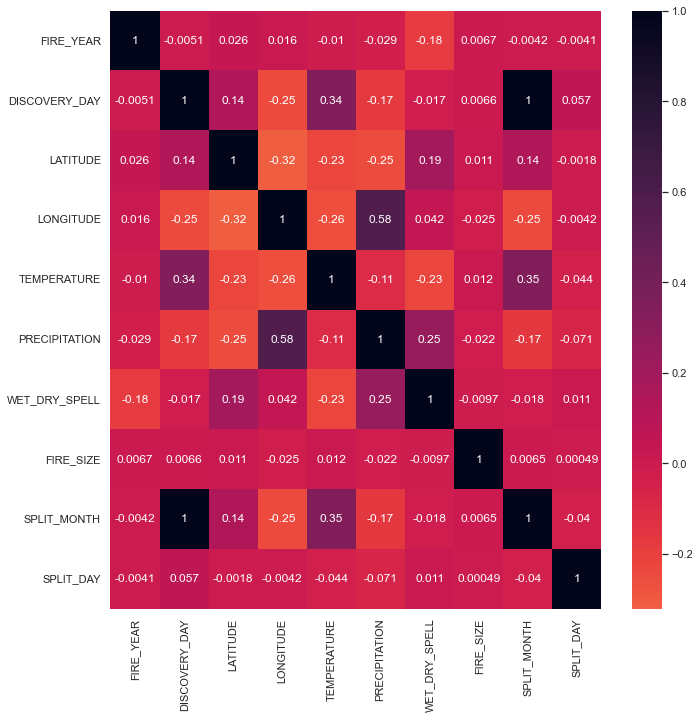

In [17]:
# Affichage de la corrélation sous forme de heatmap
plt.figure(figsize=(11,11))
sns.heatmap(fires_model.corr(), annot=True,center=0,cmap='rocket_r')
plt.show()

Il n'y a pas de variables significativement corrélées, mise à part DISCOVERY_DAY et SPLIT_MONTH, ce qui est logique puisque cette dernière provient de la première.  
Celles qui sont mises en exergue sont LONGITUDE et PRECIPITATION : plus l'un augmente, plus l'autre augmente. La relation parait logique puisqu'en fonction de la position sur le globe il y a plus ou moins de précipitation

In [18]:
# ANOVA pour la température moyenne
import statsmodels.api
result_tmp = statsmodels.formula.api.ols('TEMPERATURE ~ STAT_CAUSE_DESCR', data=fires_model).fit()
table_tmp = statsmodels.api.stats.anova_lm(result_tmp)
table_tmp

,df,sum_sq,mean_sq,F,PR(>F)
STAT_CAUSE_DESCR,12.0,3.520801e+07,2.934001e+06,18562.715459,0.0
Residual,1835567.0,2.901275e+08,1.580588e+02,NaN,NaN


La p-value est inférieure à 0.05% donc il existe une relation entre les variables.  
La F statistic est élevée, les 2 variables sont fortement liées

In [19]:
# ANOVA pour la précipitation moyenne
result_pcp = statsmodels.formula.api.ols('PRECIPITATION ~ STAT_CAUSE_DESCR', data=fires_model).fit()
table_pcp = statsmodels.api.stats.anova_lm(result_pcp)
table_pcp

,df,sum_sq,mean_sq,F,PR(>F)
STAT_CAUSE_DESCR,12.0,3.656719e+05,30472.660410,9107.480563,0.0
Residual,1835567.0,6.141612e+06,3.345894,NaN,NaN


La p-value est inférieure à 0.05% donc il existe une relation entre les variables.  
La F statistic est élevée, les 2 variables sont fortement liées

In [20]:
# ANOVA pour l'indice de sécheresse et d'humidité moyens
result_dro = statsmodels.formula.api.ols('WET_DRY_SPELL ~ STAT_CAUSE_DESCR', data=fires_model).fit()
table_dro = statsmodels.api.stats.anova_lm(result_dro)
table_dro

,df,sum_sq,mean_sq,F,PR(>F)
STAT_CAUSE_DESCR,12.0,1.153118e+05,9609.319721,1346.097824,0.0
Residual,1835567.0,1.310347e+07,7.138649,NaN,NaN


La p-value est inférieure à 0.05% donc il existe une relation entre les variables.  
La F statistic est plus faible que les 2 précédentes, les indices de sécheresse et d'humidité semblent être moins corrélés que les températures et précipitations moyennes

## Variables catégorielles et numériques

In [21]:
# Analyse du type de données afin de préparer les données finales 
#fires_model.info()
print(fires_model.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1835580 entries, 0 to 1880464
Data columns (total 16 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   STAT_CAUSE_DESCR         object 
 1   FIRE_SIZE_CLASS          object 
 2   STATE                    object 
 3   DAY                      object 
 4   FIRE_YEAR                int32  
 5   DISCOVERY_DAY            int64  
 6   LATITUDE                 float64
 7   LONGITUDE                float64
 8   TEMPERATURE              float64
 9   PRECIPITATION            float64
 10  WET_DRY_SPELL            float64
 11  CLIMAT                   object 
 12  FIRE_SIZE                float64
 13  SPLIT_MONTH              int32  
 14  SPLIT_DAY                int64  
 15  concat_state_year_month  object 
dtypes: float64(6), int32(2), int64(2), object(6)
memory usage: 224.1+ MB
None


In [22]:
# Variables numériques
num_var = fires_model.select_dtypes(include=[np.number])
print(num_var.shape)

# Variables catégorielles
cat_var = fires_model.select_dtypes(include=[object])
print(cat_var.shape)

# Vérification de la non perte de données
print(fires_model.shape)
print('Les dimensions sont conformes, aucune perte de données')

(1835580, 10)
(1835580, 6)
(1835580, 16)
Les dimensions sont conformes, aucune perte de données


In [23]:
# Variables numériques
num_var = fires_model.select_dtypes(include=[np.number])
print(num_var.shape)
num_var

(1835580, 10)


,FIRE_YEAR,DISCOVERY_DAY,LATITUDE,LONGITUDE,TEMPERATURE,PRECIPITATION,WET_DRY_SPELL,FIRE_SIZE,SPLIT_MONTH,SPLIT_DAY
0,2005,33,40.036944,-121.005833,47.1,4.03,2.28,0.10,2,2
1,2004,133,38.933056,-120.404444,63.2,0.45,-2.15,0.25,5,12
2,2004,152,38.984167,-120.735556,63.2,0.45,-2.15,0.10,5,31
3,2004,180,38.559167,-119.913333,70.4,0.08,-2.80,0.10,6,28
4,2004,180,38.559167,-119.933056,70.4,0.08,-2.80,0.10,6,28
...,...,...,...,...,...,...,...,...,...,...
1880460,2015,269,40.481637,-122.389375,72.1,0.33,-4.48,0.01,9,26
1880461,2015,278,37.617619,-120.938570,65.0,0.90,-4.48,0.20,10,5
1880462,2015,122,37.617619,-120.938570,60.8,0.93,-5.11,0.10,5,2
1880463,2015,287,37.672235,-120.898356,65.0,0.90,-4.48,2.00,10,14


In [24]:
# Conversion des acres en km² => 1 acre = 40.47 ares = 0.004 km²
num_var['FIRE_SIZE'] = num_var['FIRE_SIZE']*0.004
# La colonne FIRE_SIZE_CLASS n'a pas besoin d'être revue puisqu'elle suit proportionnellement la colonne FIRE_SIZE.

# Conversion de la température moyenne en degré celsius => °C = ((°F-32)/1.8)
num_var['TEMPERATURE'] = round((num_var['TEMPERATURE']-32)/1.8,2)

# Conversion de la précipitation moyenne en cm => 1 inch = 2.54 cm
num_var['PRECIPITATION'] = round(num_var['PRECIPITATION']*2.54,2)


## Vérification outliers sur variables numériques

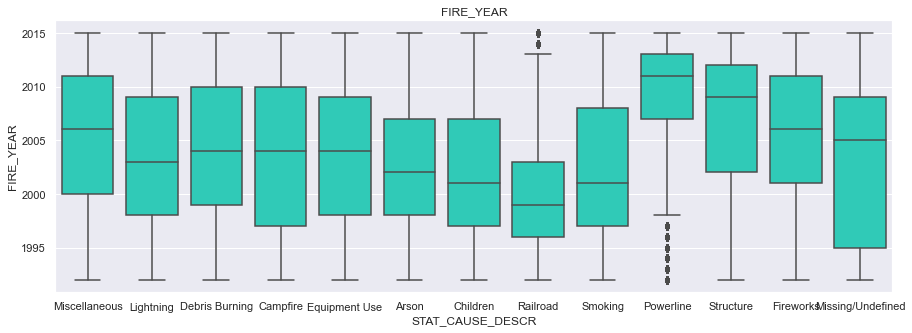

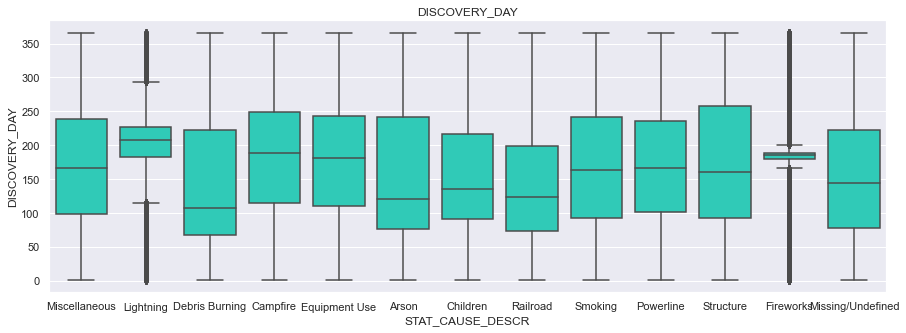

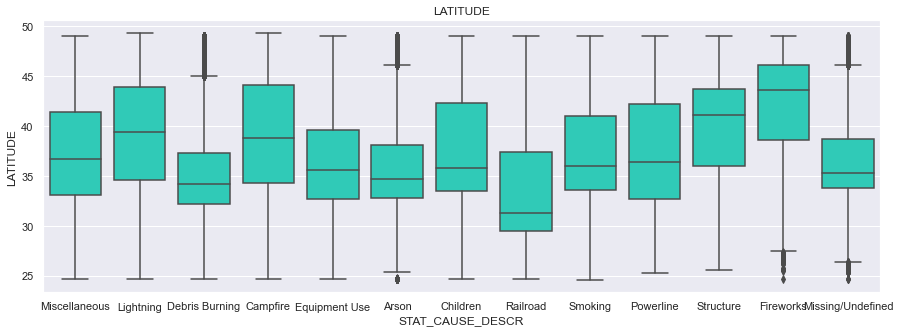

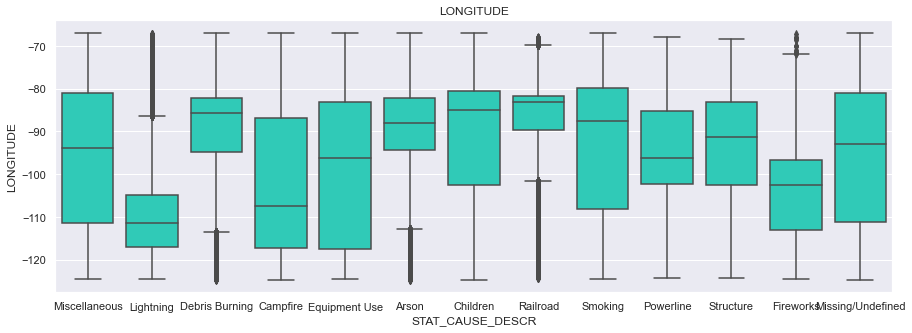

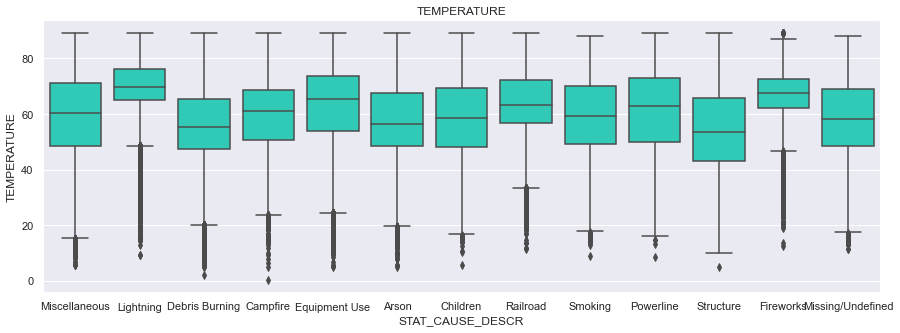

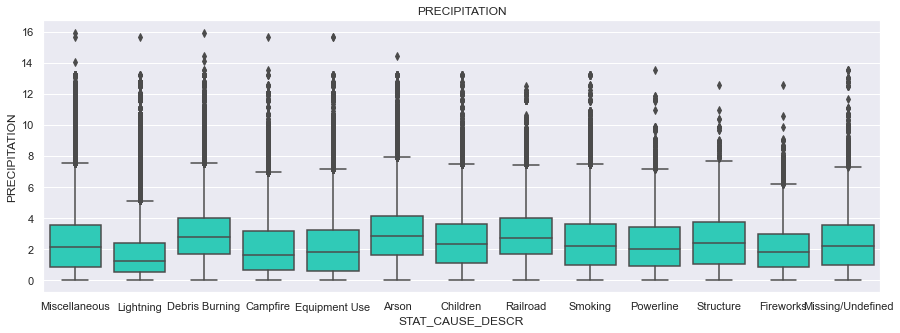

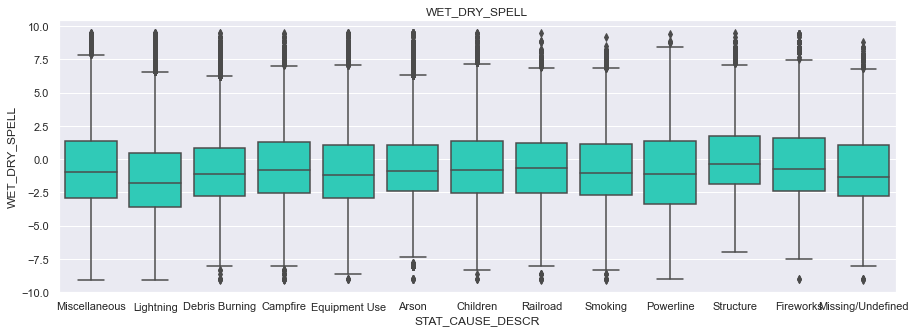

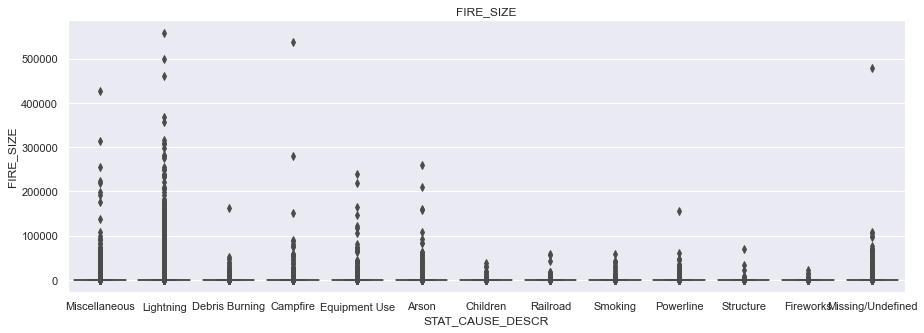

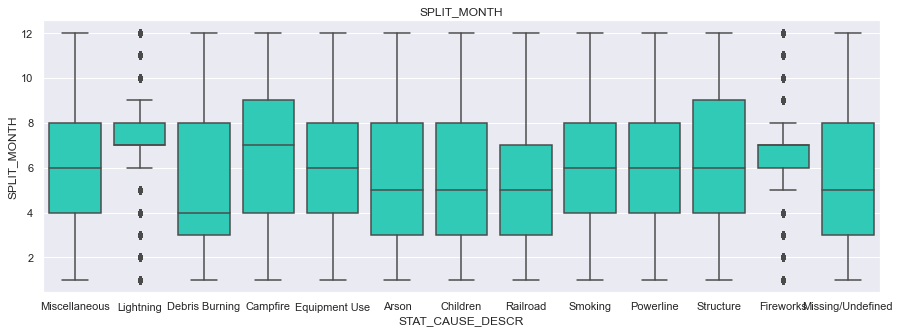

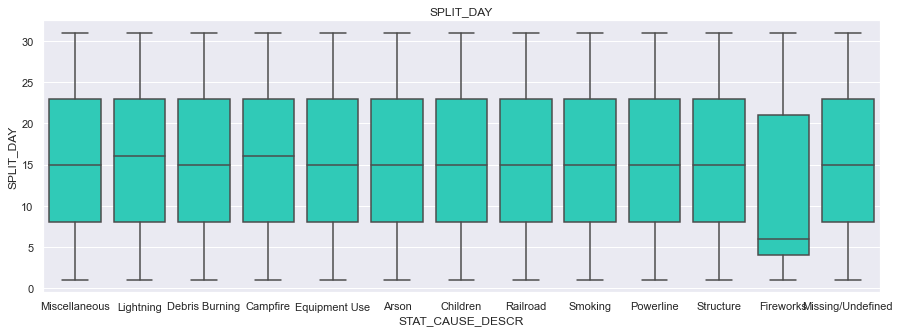

In [25]:
#En statistique, une valeur aberrante (ou outlier en anglais) est une observation qui est "distante" des autres valeurs de la même variable, c'est-à-dire qu'elle contraste grandement avec le reste des valeurs mesurées.
#Une valeur aberrante peut être due à une variabilité inhérente au phénomène observé ou peut aussi indiquer une erreur expérimentale.
#C'est pourquoi elles sont parfois exclues des données.

Col = num_var

for i in Col:
    fig, axs = plt.subplots(1, 1, figsize=(15, 5))
    sns.boxplot(y=fires_model[i], x=fires_model['STAT_CAUSE_DESCR'], ax=axs, color='#16E4CA')
    plt.title(i)

In [26]:
print('Résultat: \n')
print('- LATITUTE ET LONGITUTE: cela peut varier considerablement, aucun changement ou supression des outliers')
print('- Données datées : FIRE_YEAR, SPLIT_MONTH, SPLIT_DAY, DISCOVERY_DAY. Ces données restent cohérentes (12 mois par année, 30 jours par mois et 365 jours par an.)')
print("- Données météorologiques : très variables donc aucun changement ou suppression d'outliers. \n")
print('Par contre on voit des outlier marquants sur FIRE_SIZE')
      
print('Quantité outliers FIRE_SIZE:' , fires_model['FIRE_SIZE'][fires_model['FIRE_SIZE']>400000].shape, 'vs', fires_model['FIRE_SIZE'].shape, 'en total')


Résultat: 

- LATITUTE ET LONGITUTE: cela peut varier considerablement, aucun changement ou supression des outliers
- Données datées : FIRE_YEAR, SPLIT_MONTH, SPLIT_DAY, DISCOVERY_DAY. Ces données restent cohérentes (12 mois par année, 30 jours par mois et 365 jours par an.)
- Données météorologiques : très variables donc aucun changement ou suppression d'outliers. 

Par contre on voit des outlier marquants sur FIRE_SIZE
Quantité outliers FIRE_SIZE: (6,) vs (1835580,) en total


In [27]:
#supression outliers FIRE_SIZE

fires_model = fires_model[fires_model['FIRE_SIZE']<400000]

fires_model.shape

(1835574, 16)

In [28]:
# Etude et encodage des variables catégorielles
print(cat_var.nunique())

STAT_CAUSE_DESCR              13
FIRE_SIZE_CLASS                7
STATE                         48
DAY                            7
CLIMAT                         5
concat_state_year_month    11879
dtype: int64


In [29]:
# Regroupement de la variable catégorielle STAT_CAUSE_DESCR par type de cause 
def change_cause(cat):
    cause = 0
    natural_cause = ['Lightning']
    accidental_cause = ['Structure','Fireworks','Powerline','Railroad','Smoking','Children','Campfire','Equipment Use','Debris Burning']
    criminal_cause = ['Arson']
    other_cause = ['Missing/Undefined','Miscellaneous']
    if cat in natural_cause:
        cause = 2
    elif cat in accidental_cause:
        cause = 3
    elif cat in criminal_cause:
        cause = 4
    else:
        cause = 1
    return cause

cat_var['CAUSE'] = cat_var['STAT_CAUSE_DESCR'].apply(lambda x: change_cause(x))

cat_var


,STAT_CAUSE_DESCR,FIRE_SIZE_CLASS,STATE,DAY,CLIMAT,concat_state_year_month,CAUSE
0,Miscellaneous,A,CA,Wednesday,mediteraneen,CA-2005-2,1
1,Lightning,A,CA,Wednesday,mediteraneen,CA-2004-5,2
2,Debris Burning,A,CA,Monday,mediteraneen,CA-2004-5,3
3,Lightning,A,CA,Monday,mediteraneen,CA-2004-6,2
4,Lightning,A,CA,Monday,mediteraneen,CA-2004-6,2
...,...,...,...,...,...,...,...
1880460,Missing/Undefined,A,CA,Saturday,mediteraneen,CA-2015-9,1
1880461,Miscellaneous,A,CA,Monday,mediteraneen,CA-2015-10,1
1880462,Missing/Undefined,A,CA,Saturday,mediteraneen,CA-2015-5,1
1880463,Missing/Undefined,B,CA,Wednesday,mediteraneen,CA-2015-10,1


In [30]:
cat_var = cat_var.join(pd.get_dummies(cat_var['CLIMAT'], prefix='CLIMAT'))
cat_var

,STAT_CAUSE_DESCR,FIRE_SIZE_CLASS,STATE,DAY,CLIMAT,concat_state_year_month,CAUSE,CLIMAT_continental humide ete frais,CLIMAT_continental humide ete sec,CLIMAT_mediteraneen,CLIMAT_steppe,CLIMAT_subtropical
0,Miscellaneous,A,CA,Wednesday,mediteraneen,CA-2005-2,1,0,0,1,0,0
1,Lightning,A,CA,Wednesday,mediteraneen,CA-2004-5,2,0,0,1,0,0
2,Debris Burning,A,CA,Monday,mediteraneen,CA-2004-5,3,0,0,1,0,0
3,Lightning,A,CA,Monday,mediteraneen,CA-2004-6,2,0,0,1,0,0
4,Lightning,A,CA,Monday,mediteraneen,CA-2004-6,2,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1880460,Missing/Undefined,A,CA,Saturday,mediteraneen,CA-2015-9,1,0,0,1,0,0
1880461,Miscellaneous,A,CA,Monday,mediteraneen,CA-2015-10,1,0,0,1,0,0
1880462,Missing/Undefined,A,CA,Saturday,mediteraneen,CA-2015-5,1,0,0,1,0,0
1880463,Missing/Undefined,B,CA,Wednesday,mediteraneen,CA-2015-10,1,0,0,1,0,0


In [31]:
# Import
from sklearn.preprocessing import LabelEncoder

# Instanciation
le = LabelEncoder()

# Encodage des variables catégorielles 
cat_var['STATE'] = le.fit_transform(cat_var['STATE'])

## Reconstitution du DataFrame

In [32]:
# Reconstitution du DataFrame
fires_model = pd.concat([cat_var, num_var], axis=1)

In [33]:
# Intéressons-nous uniquement aux jours appartenant ou non à un week-end : nous avons remarqué précédemment que les feux apparaissaient significativement les samedis et dimanches, 
# Les autres jours de la semaine ont un nombre de feux quasi constants, il n'y a pas de valeur significative du lundi au vendredi.
fires_model['WEEK_END'] = [1 if day =='Saturday' or day =='Sunday' else 0 for day in fires_model['DAY']] 
fires_model

,STAT_CAUSE_DESCR,FIRE_SIZE_CLASS,STATE,DAY,CLIMAT,concat_state_year_month,CAUSE,CLIMAT_continental humide ete frais,CLIMAT_continental humide ete sec,CLIMAT_mediteraneen,...,DISCOVERY_DAY,LATITUDE,LONGITUDE,TEMPERATURE,PRECIPITATION,WET_DRY_SPELL,FIRE_SIZE,SPLIT_MONTH,SPLIT_DAY,WEEK_END
0,Miscellaneous,A,3,Wednesday,mediteraneen,CA-2005-2,1,0,0,1,...,33,40.036944,-121.005833,8.39,10.24,2.28,0.00040,2,2,0
1,Lightning,A,3,Wednesday,mediteraneen,CA-2004-5,2,0,0,1,...,133,38.933056,-120.404444,17.33,1.14,-2.15,0.00100,5,12,0
2,Debris Burning,A,3,Monday,mediteraneen,CA-2004-5,3,0,0,1,...,152,38.984167,-120.735556,17.33,1.14,-2.15,0.00040,5,31,0
3,Lightning,A,3,Monday,mediteraneen,CA-2004-6,2,0,0,1,...,180,38.559167,-119.913333,21.33,0.20,-2.80,0.00040,6,28,0
4,Lightning,A,3,Monday,mediteraneen,CA-2004-6,2,0,0,1,...,180,38.559167,-119.933056,21.33,0.20,-2.80,0.00040,6,28,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880460,Missing/Undefined,A,3,Saturday,mediteraneen,CA-2015-9,1,0,0,1,...,269,40.481637,-122.389375,22.28,0.84,-4.48,0.00004,9,26,1
1880461,Miscellaneous,A,3,Monday,mediteraneen,CA-2015-10,1,0,0,1,...,278,37.617619,-120.938570,18.33,2.29,-4.48,0.00080,10,5,0
1880462,Missing/Undefined,A,3,Saturday,mediteraneen,CA-2015-5,1,0,0,1,...,122,37.617619,-120.938570,16.00,2.36,-5.11,0.00040,5,2,1
1880463,Missing/Undefined,B,3,Wednesday,mediteraneen,CA-2015-10,1,0,0,1,...,287,37.672235,-120.898356,18.33,2.29,-4.48,0.00800,10,14,0


In [34]:
# Suppression des colonnes inutiles
fires_model = fires_model.drop(['DAY','CLIMAT','DISCOVERY_DAY','SPLIT_MONTH','SPLIT_DAY','concat_state_year_month'],axis=1).reset_index(drop=True)

In [35]:
# Renommage des colonnes
fires_model = fires_model.rename(columns=({'CLIMAT_continental humide ete frais':'CLIMAT_CONT_HUM_ETE_FRAIS','CLIMAT_continental humide ete sec':'CLIMAT_CONT_HUM_ETE_SEC','CLIMAT_mediteraneen':'CLIMAT_MEDITERRANEEN','CLIMAT_steppe':'CLIMAT_STEPPE','CLIMAT_subtropical':'CLIMAT_SUBTROPICAL'}))
fires_model

,STAT_CAUSE_DESCR,FIRE_SIZE_CLASS,STATE,CAUSE,CLIMAT_CONT_HUM_ETE_FRAIS,CLIMAT_CONT_HUM_ETE_SEC,CLIMAT_MEDITERRANEEN,CLIMAT_STEPPE,CLIMAT_SUBTROPICAL,FIRE_YEAR,LATITUDE,LONGITUDE,TEMPERATURE,PRECIPITATION,WET_DRY_SPELL,FIRE_SIZE,WEEK_END
0,Miscellaneous,A,3,1,0,0,1,0,0,2005,40.036944,-121.005833,8.39,10.24,2.28,0.00040,0
1,Lightning,A,3,2,0,0,1,0,0,2004,38.933056,-120.404444,17.33,1.14,-2.15,0.00100,0
2,Debris Burning,A,3,3,0,0,1,0,0,2004,38.984167,-120.735556,17.33,1.14,-2.15,0.00040,0
3,Lightning,A,3,2,0,0,1,0,0,2004,38.559167,-119.913333,21.33,0.20,-2.80,0.00040,0
4,Lightning,A,3,2,0,0,1,0,0,2004,38.559167,-119.933056,21.33,0.20,-2.80,0.00040,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1835575,Missing/Undefined,A,3,1,0,0,1,0,0,2015,40.481637,-122.389375,22.28,0.84,-4.48,0.00004,1
1835576,Miscellaneous,A,3,1,0,0,1,0,0,2015,37.617619,-120.938570,18.33,2.29,-4.48,0.00080,0
1835577,Missing/Undefined,A,3,1,0,0,1,0,0,2015,37.617619,-120.938570,16.00,2.36,-5.11,0.00040,1
1835578,Missing/Undefined,B,3,1,0,0,1,0,0,2015,37.672235,-120.898356,18.33,2.29,-4.48,0.00800,0


# PCA

In [36]:
# Import des packages
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [39]:
# Séparation des données d'entrainement et des données cibles
data = fires_model.drop(['FIRE_SIZE_CLASS','CAUSE','STAT_CAUSE_DESCR'], axis=1)
target = fires_model['CAUSE']

In [40]:
# Création instance StandardScaler
scaler = StandardScaler()
# Normalisation des données
norm = scaler.fit_transform(data)

# Création de l'instance PCA
model_pca = PCA()

# Stockage de la représentation de data normalisée obtenue par Analyse en Composantes Principales dans un array nommé coord_acp
coord_acp = model_pca.fit_transform(norm)

In [41]:
# Part de variance expliquée pour chaque composante => valeurs propres de la matrice. 
# Elles nous indiquent la part de l'ensemble de l'information contenue sur chaque facteur.
var_expl = model_pca.explained_variance_
print(var_expl)

[3.12220750e+00 2.28855175e+00 1.43319135e+00 1.16751826e+00
 1.06793106e+00 1.00014444e+00 9.96757018e-01 7.99423327e-01
 7.53662322e-01 6.44744970e-01 4.12169104e-01 2.07960888e-01
 1.05745640e-01 1.93717288e-25]


In [42]:
# Dimension de la variance expliquée
var_expl.shape

(14,)

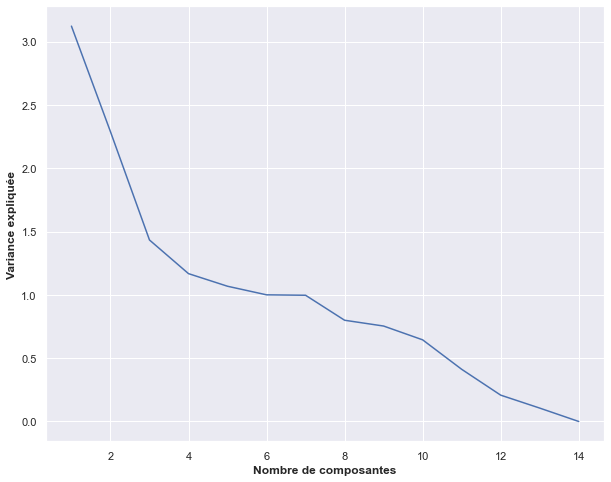

In [43]:
# Graphique de la variance expliquée en fonction du nombre de facteurs
plt.figure(figsize=(10,8))
plt.plot(np.arange(1,15), var_expl)
plt.xlabel('Nombre de composantes', weight='bold') # Nombre de facteurs
plt.ylabel('Variance expliquée', weight='bold') # Valeurs propres
plt.show()

In [44]:
# Ratio de la variance expliquée pour chacune des composantes
ratio_var = model_pca.explained_variance_ratio_ 
ratio_var

array([2.23014700e-01, 1.63467893e-01, 1.02370755e-01, 8.33941157e-02,
       7.62807487e-02, 7.14388499e-02, 7.11968910e-02, 5.71016351e-02,
       5.38329937e-02, 4.60531870e-02, 2.94406342e-02, 1.48543410e-02,
       7.55325586e-03, 1.38369416e-26])

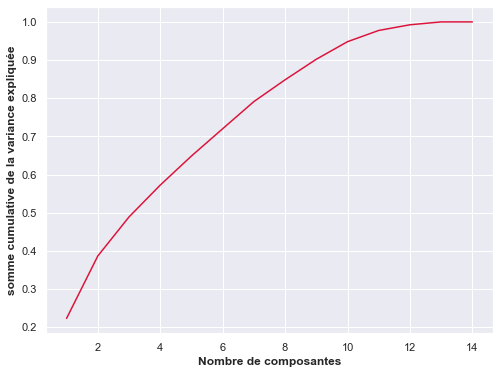

In [45]:
# Graphique de la somme cumulative représentant le ratio de la variance expliquée en fonction du nombre de composantes
plt.figure(figsize=(8,6))

plt.plot(np.arange(1, 15), np.cumsum(ratio_var), color = 'crimson')

plt.xlabel('Nombre de composantes', weight='bold') # Nombre de facteurs
plt.ylabel('somme cumulative de la variance expliquée', weight='bold')

plt.show()

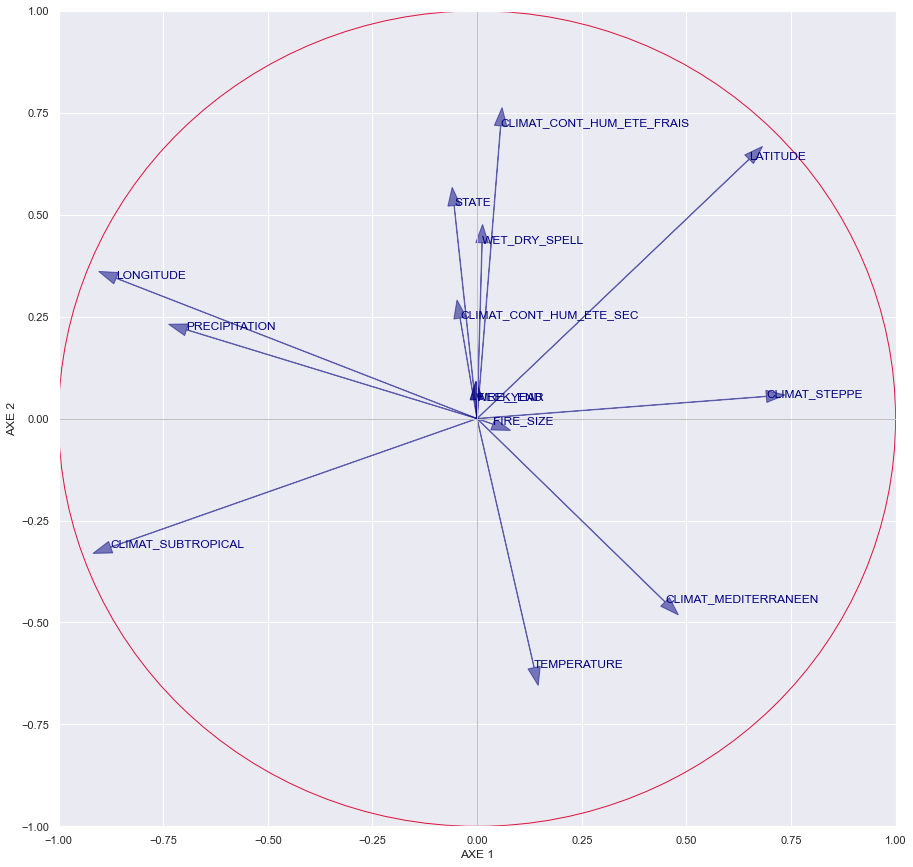

In [46]:
sqrt_eigval = np.sqrt(model_pca.explained_variance_)
corvar = np.zeros((14, 14))
for k in range(14):
    corvar[:, k] = model_pca.components_[k, :] * sqrt_eigval[k]
# corvar

fig, axes = plt.subplots(figsize=(15, 15))
axes.set_xlim(-1, 1)
axes.set_ylim(-1, 1)

# affichage des étiquettes (noms des variables)
for j in range(14):
    plt.annotate(data.columns[j], (corvar[j, 0], corvar[j, 1]), color='navy')
    plt.arrow(0, 0, corvar[j, 0], corvar[j, 1], alpha=0.5, head_width=0.03, color='navy')

# ajouter les axes
plt.plot([-1, 1], [0, 0], color='silver', linestyle='-', linewidth=1)
plt.plot([0, 0], [-1, 1], color='silver', linestyle='-', linewidth=1)

cercle = plt.Circle((0, 0), 1, color='crimson', fill=False)
axes.add_artist(cercle)
plt.xlabel('AXE 1')
plt.ylabel('AXE 2')
plt.show()

Un cercle de corrélation permet de lire la corrélation de chaque variable avec les axes 1 et 2.  
Si une flèche est courte, cela veut dire que la variable est peu corrélée à l'axe, elle est mal représentée, on a perdu une très grande partie de l'information que contenait cette variable. Il ne faut donc pas l'interpréter.  
Pour les flèches plus longues, si elles sont verticales ou horizontales par rapport aux axes, cela veut dire qu'il existe une très forte corrélation.  
Si la pointe est proche du cercle, la variable est très bien représentée dans le plan défini par les axes 1 et 2.

Dans le cercle des corrélations nous voyons bien qu'il n'y a pas de très forte corrélation bien représentée mise à part le climat steppe par rapport à l'axe 1 et le CLIMAT CONTINENTAL HUMIDE ETE FRAIS par rapport à l'axe 2. 
Les variables LONGITUDE, PRECIPITATION, TEMPERATURE et CLIMAT_SUBTROPICAL sont très fortement représentées mais ne sont pas fortement corrélées.

In [47]:
# Création d'un dataframe avec uniquement les 2 premières coordonnées de PCA
acp_data = pd.DataFrame({'axe1':coord_acp[:,0], 'axe2':coord_acp[:,1], 'target':target})

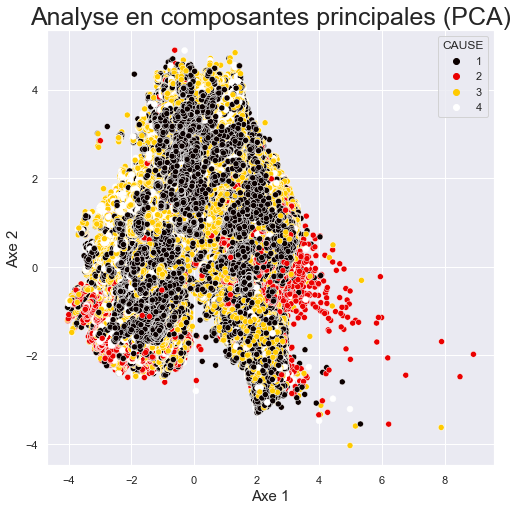

In [48]:
# Représentation graphique du nuage de points
plt.figure(figsize=(8,8))

sns.scatterplot(x='axe1', y='axe2', hue= target, data=acp_data, palette='hot')

plt.title('Analyse en composantes principales (PCA)', fontsize=25)
plt.xlabel('Axe 1', fontsize=15)
plt.ylabel('Axe 2', fontsize=15)

plt.show()

Résultat : Il n'y a pas de distinction entre chaque cause. Le résultat n'est pas interprétable.

# T-SNE

L'objectif de T-SNE est similaire à celui de l'ACP : représenter nos données dans une dimension plus petite.  
Cependant, le principe de T-SNE est différent :  
Il construit une nouvelle représentation des données de manière à ce que les données proches dans la dimension d'origine aient une forte probabilité d'avoir des représentations proches dans la nouvelle dimension.

In [49]:
# Import
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

In [50]:
# Création de l'instance T-SNE
tsne = TSNE(n_components=2)

# Import de la fonction random pour pouvoir sélectionner aléatoirement 10000 données du dataset normalisé
import random
idx = [i for i in range(len(target))]
idx_aleatoire = random.choices(idx, k=10000)
# Stockage de la représentation de data normalisée avec 1% des données intiales aléatoires afin de ne pas trop bloquer le lancement
# Pour mémoire : time 2 à 5min.
Coord_TSNE = tsne.fit_transform(norm[idx_aleatoire])

In [51]:
# DataFrame tsne_df contenant les coordonnées Coord_TSNE ainsi que la variable target avec 1% des données initiales.
tsne_df = pd.DataFrame({'AXE 1': Coord_TSNE[:, 0], 'AXE 2': Coord_TSNE[:, 1], 'Target': target[idx_aleatoire]}).reset_index(drop=True)

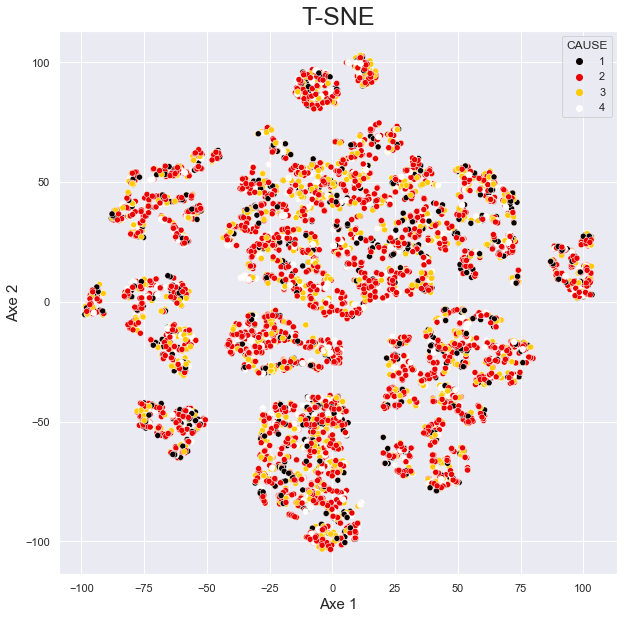

In [52]:
# Représentation graphique de 1% des données

plt.figure(figsize=(10,10))

sns.scatterplot(x='AXE 1', y='AXE 2', hue= target, data=tsne_df, palette='hot')

plt.title('T-SNE', fontsize=25)
plt.xlabel('Axe 1', fontsize=15)
plt.ylabel('Axe 2', fontsize=15)

plt.show()

Résultat : Là encore le résultat n'est pas concluant. Aucun groupe ne se dégage de ce nuage de points.

### T-SNE + PCA

In [53]:
# Création d'une nouvelle isntance de TSNE
tsne_new = TSNE(n_components=2)

# Stockage des coordonnées du T-SNE sur celles de l'ACP avec 1% des données
# Pour mémoire : time 2 à 5min. 
Coord_TSNE_ACP = tsne_new.fit_transform(coord_acp[idx_aleatoire])

In [54]:
# Création d'un nouveau DataFrame tsne_acp_df contenant Coord_TSNE_ACP et la variable target
tsne_acp_df = pd.DataFrame({'AXE 1': Coord_TSNE_ACP[:, 0], 'AXE 2': Coord_TSNE_ACP[:, 1], 'Target': target[idx_aleatoire]}).reset_index(drop=True)

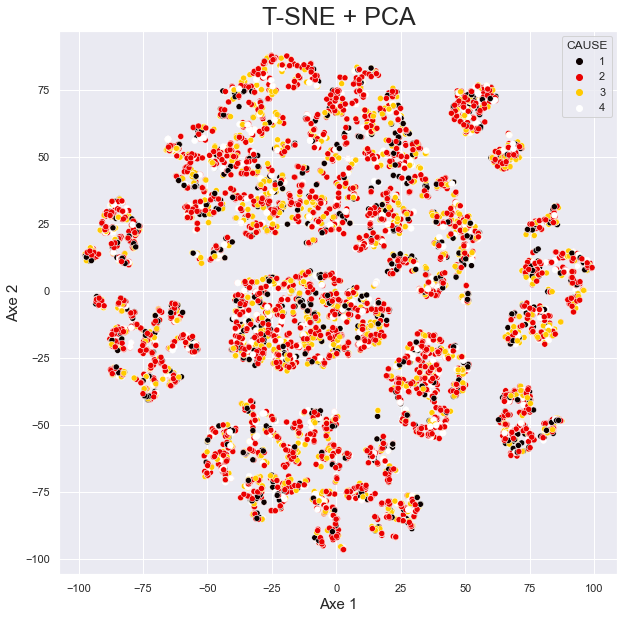

In [55]:
# Représentation graphique
plt.figure(figsize=(10,10))

sns.scatterplot(x='AXE 1', y='AXE 2', hue= target, data=tsne_acp_df, palette='hot')

plt.title('T-SNE + PCA', fontsize=25)
plt.xlabel('Axe 1', fontsize=15)
plt.ylabel('Axe 2', fontsize=15)

plt.show()

Résultat : Le résultat n'est toujours pas concluant, nous ne pouvons pas interpréter le graphique

## K-MEANS

In [56]:
# import
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

fires_model_for_kmeans = fires_model[['LONGITUDE','LATITUDE']]

# Standardisation des données
sc = StandardScaler()
fires_model_norm = sc.fit_transform(fires_model_for_kmeans)

## Choix du nombre de clusters optimal - méthode 1

In [57]:
# Import de la fonction permettant de calculer la distance entre les observations de dimension quelconque
from scipy.spatial.distance import cdist

# Pour mémoire, time entre 15 et 27 min pour (1,20)
# Liste de k à tester
list_n_clusters = list(range(1,20))

# Initialisation de la liste de distorsions
distorsions = []
# Calcul des distorsions pour les différents modèles
for n_clusters in list_n_clusters :
    # Initialisation d'un cluster ayant un pour nombre de clusters n_clusters
    cluster = KMeans(n_clusters = n_clusters)
    # Apprentissage des données suivant le cluster construit ci-dessus
    cluster.fit(fires_model_norm)
    # Ajout de la nouvelle distorsion à la liste des données
    distorsions.append(sum(np.min(cdist(fires_model_norm, cluster.cluster_centers_, 'euclidean'), axis=1)) / np.size(fires_model_norm, axis = 0))


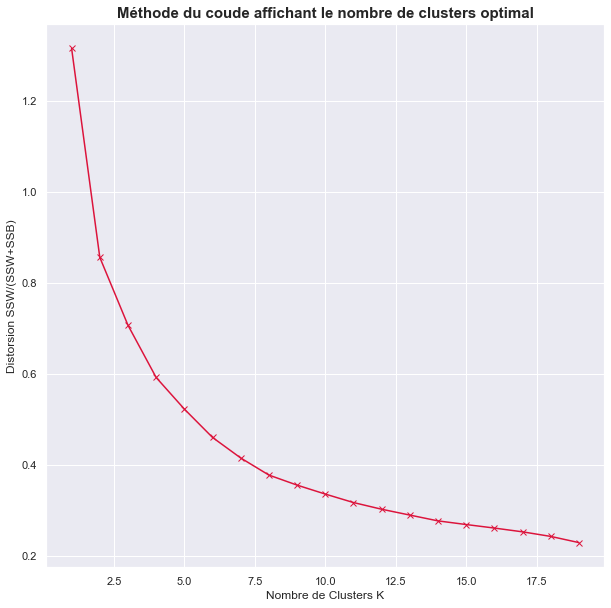

In [58]:
# Représentation grahpique des distorsions en fonction du nombre de clusters
plt.figure(figsize=(10,10))

plt.plot(list_n_clusters, distorsions, marker='x', c='crimson')

plt.xlabel('Nombre de Clusters K')
plt.ylabel('Distorsion SSW/(SSW+SSB)')
plt.title('Méthode du coude affichant le nombre de clusters optimal', fontsize=15, weight='semibold')

plt.show()

Interprétation : I n'y a pas de coude visible mais on observe qu'à partir de 6 composantes on obtient un maximum d'info et au delà, on ne peut pas obtenir davantage.

## Choix du nombre de clusters optimal - méthode 2

Text(0, 0.5, 'K-Means inertia')

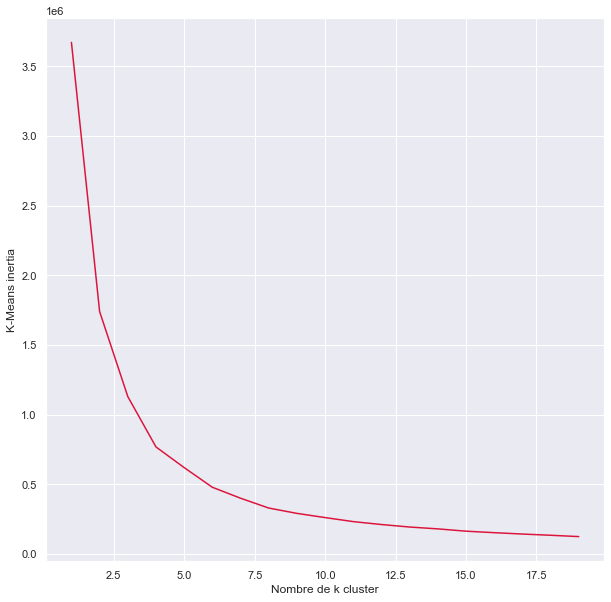

In [59]:
# Cette méthode consiste à tracer la variation expliquée en fonction du nombre de clusters, 
# et à choisir le coude de la courbe comme le nombre de clusters à utiliser
# Pour mémoire : time > 14min.
L = []
for i in range(1,20):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(fires_model_norm)
    L.append(kmeans.inertia_)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(range(1, 20), L, c='crimson')
plt.xlabel('Nombre de k cluster')
plt.ylabel('K-Means inertia')

Interprétation : La trajectoire de la courbe est un peu plus interprétable et on peut voir qu'à partir de 5 clusters, on obtient un maximum d'info

## Représentation graphique

### 5 clusters  

In [60]:
# Création de l'instance KMeans
kmeans = KMeans(n_clusters=5)

# Ajustement 
kmeans.fit(fires_model_norm)

# Prédictions
y_kmeans = kmeans.predict(fires_model_norm)

In [61]:
fires_model_norm_kmeans = pd.DataFrame(fires_model_norm, columns=['LONGITUDE','LATITUDE'])
fires_model_norm_kmeans

,LONGITUDE,LATITUDE
0,-1.673741,0.588878
1,-1.634511,0.381263
2,-1.656110,0.390875
3,-1.602476,0.310943
4,-1.603762,0.310943
...,...,...
1835575,-1.763991,0.672514
1835576,-1.669353,0.133860
1835577,-1.669353,0.133860
1835578,-1.666730,0.144132


In [62]:
# Coordonnées des clusters / liste des positions des K centroïdes
centroids = kmeans.cluster_centers_
centroids

array([[-1.23921133,  1.49651749],
       [ 0.73089876, -0.306534  ],
       [ 0.89686241,  1.19306245],
       [ 0.40171511, -1.07626922],
       [-1.24348381, -0.08444951]])

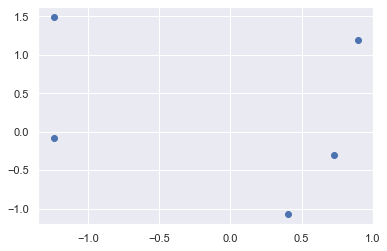

In [63]:
# Graphique des centroïdes
plt.scatter(centroids[:, 0],centroids[:, 1])
plt.show()

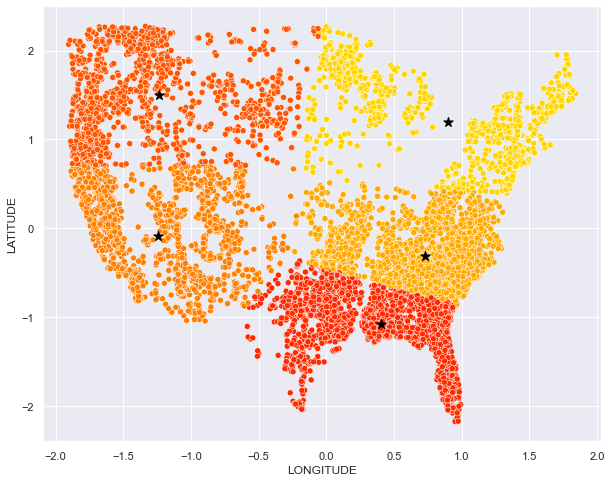

In [64]:
# Pour créer la colonne des clusters dans le dataframe 
fires_model_norm_kmeans['cluster']=y_kmeans

# on teste sur un échantillon
fires_model_norm_kmeans_echantillon = fires_model_norm_kmeans.sample(10000)

# penser à mettre en chaine de caratère les clusters pour les avoir tous dans la légende
plt.figure(figsize=(10,8))
sns.scatterplot(x=fires_model_norm_kmeans_echantillon.LONGITUDE,y=fires_model_norm_kmeans_echantillon.LATITUDE,palette='autumn',hue=fires_model_norm_kmeans_echantillon.cluster.astype('str'),legend=False)
plt.scatter(centroids[:, 0],centroids[:, 1], s=100, c='black', label='Centroids', marker='*')
plt.show()

In [65]:
fires_model_norm_kmeans_echantillon.cluster.value_counts()

1    2723
3    2647
4    1929
0    1383
2    1318
Name: cluster, dtype: int64

### 48 clusters = 1 pour chaque Etat

In [66]:
# Création de l'instance KMeans
# Pour mémoire : time > 3min.
kmeans = KMeans(n_clusters=48)

# Ajustement 
kmeans.fit(fires_model_norm)

# Prédictions
y_kmeans = kmeans.predict(fires_model_norm)

fires_model_norm_kmeans = pd.DataFrame(fires_model_norm, columns=['LONGITUDE','LATITUDE'])

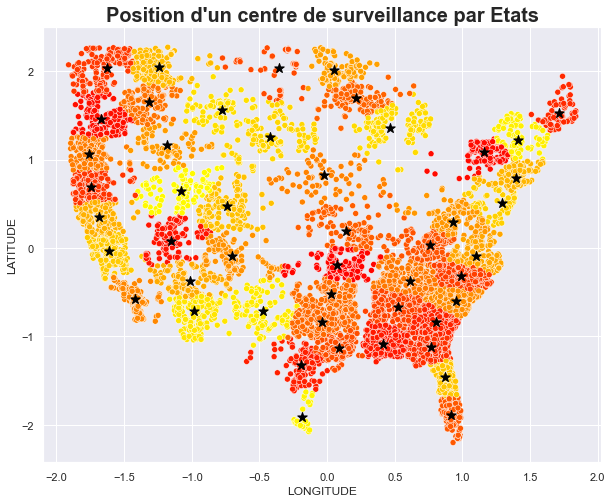

In [67]:
# Pour créer la colonne des clusters dans le dataframe 
fires_model_norm_kmeans['cluster']=y_kmeans

# on teste sur un échantillon
fires_model_norm_kmeans_echantillon = fires_model_norm_kmeans.sample(10000)

centroids = kmeans.cluster_centers_

plt.figure(figsize=(10,8))
sns.scatterplot(x=fires_model_norm_kmeans_echantillon.LONGITUDE,y=fires_model_norm_kmeans_echantillon.LATITUDE,palette='autumn',hue=fires_model_norm_kmeans_echantillon.cluster.astype('str'),legend=False)
plt.scatter(centroids[:, 0],centroids[:, 1], s=100, c='black', label='Centroids', marker='*')
plt.title("Position d'un centre de surveillance par Etats", fontweight='bold', fontsize=20)
plt.show()

## Uniquement les feux de classe G

In [68]:
fires_model_classeg = fires_model[fires_model['FIRE_SIZE_CLASS']=='G']
fires_model_g_kmeans = fires_model_classeg[['LONGITUDE','LATITUDE']]

# Standardisation des données
sc = StandardScaler()
fires_model_g_kmeans_norm = sc.fit_transform(fires_model_g_kmeans)

### 10 centres de surveillance

In [69]:
# Création de l'instance KMeans avec le nombre de cluster optimal observé sur le grahique ci-dessus
kmeans_10 = KMeans(n_clusters=10)

# Ajustement 
kmeans_10.fit(fires_model_g_kmeans_norm)

# Prédictions
y_kmeans_10 = kmeans_10.predict(fires_model_g_kmeans_norm)

df_fires_model_g_kmeans_norm_10 = pd.DataFrame(fires_model_g_kmeans_norm, columns=['LONGITUDE','LATITUDE'])

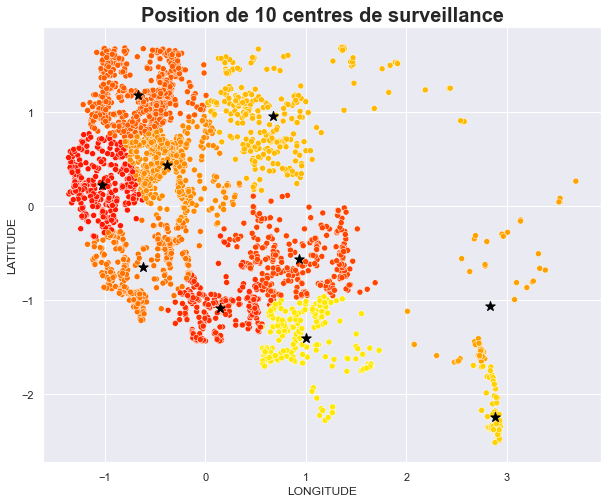

In [70]:
# Pour créer la colonne des clusters dans le dataframe 
df_fires_model_g_kmeans_norm_10['cluster']=y_kmeans_10

centroids_10 = kmeans_10.cluster_centers_

plt.figure(figsize=(10,8))
sns.scatterplot(x=df_fires_model_g_kmeans_norm_10.LONGITUDE,y=df_fires_model_g_kmeans_norm_10.LATITUDE,palette='autumn',hue=df_fires_model_g_kmeans_norm_10.cluster.astype('str'),legend=False)
plt.scatter(centroids_10[:, 0],centroids_10[:, 1], s=100, c='black', label='Centroids', marker='*')
plt.title('Position de 10 centres de surveillance', fontweight='bold', fontsize=20)
plt.show()

### 20 centres de surveillance

In [71]:
# Création de l'instance KMeans
# Pour mémoire : time 2min
kmeans_20 = KMeans(n_clusters=20)

# Ajustement 
kmeans_20.fit(fires_model_g_kmeans_norm)

# Prédictions
y_kmeans_20 = kmeans_20.predict(fires_model_g_kmeans_norm)

df_fires_model_g_kmeans_norm_20 = pd.DataFrame(fires_model_g_kmeans_norm, columns=['LONGITUDE','LATITUDE'])

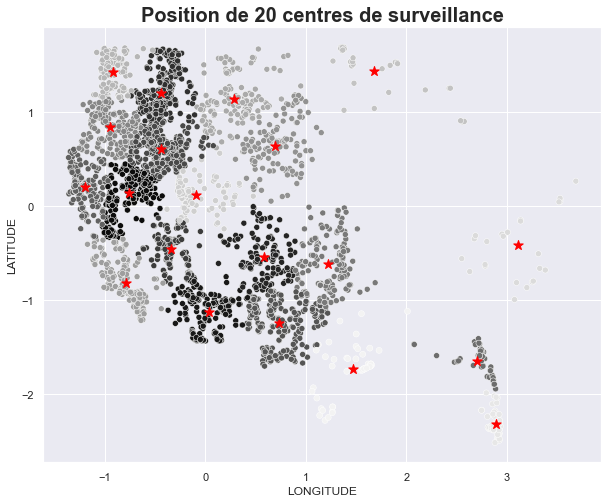

In [72]:
# Pour créer la colonne des clusters dans le dataframe 
df_fires_model_g_kmeans_norm_20['cluster']=y_kmeans_20

centroids_20 = kmeans_20.cluster_centers_

plt.figure(figsize=(10,8))
sns.scatterplot(x=df_fires_model_g_kmeans_norm_20.LONGITUDE,y=df_fires_model_g_kmeans_norm_20.LATITUDE,palette='gray',hue=df_fires_model_g_kmeans_norm_20.cluster.astype('str'), legend=False)
plt.scatter(centroids_20[:, 0],centroids_20[:, 1], s=100, c='red', label='Centroids', marker='*')
plt.title('Position de 20 centres de surveillance', fontweight='bold', fontsize=20)
plt.show()

### 50 centres de surveillance

In [73]:
# Création de l'instance KMeans
kmeans_50 = KMeans(n_clusters=50)

# Ajustement 
kmeans_50.fit(fires_model_g_kmeans_norm)

# Prédictions
y_kmeans_50 = kmeans_50.predict(fires_model_g_kmeans_norm)

df_fires_model_g_kmeans_norm_50 = pd.DataFrame(fires_model_g_kmeans_norm, columns=['LONGITUDE','LATITUDE'])

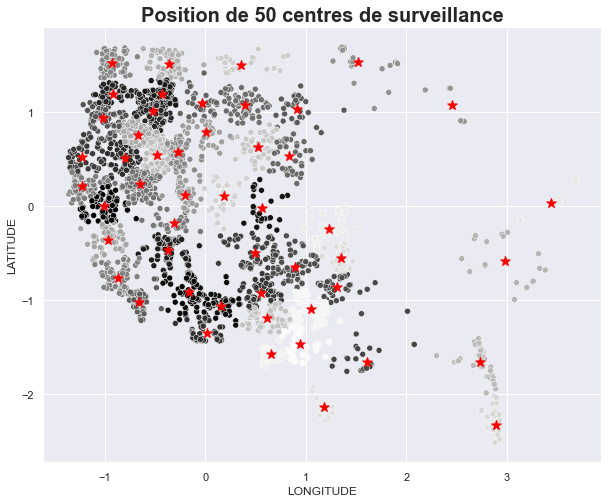

In [74]:
# Pour créer la colonne des clusters dans le dataframe 
df_fires_model_g_kmeans_norm_50['cluster']=y_kmeans_50

centroids_50 = kmeans_50.cluster_centers_

plt.figure(figsize=(10,8))
sns.scatterplot(x=df_fires_model_g_kmeans_norm_50.LONGITUDE,y=df_fires_model_g_kmeans_norm_50.LATITUDE,palette='gray',hue=df_fires_model_g_kmeans_norm_50.cluster.astype('str'), legend=False)
plt.scatter(centroids_50[:, 0],centroids_50[:, 1], s=100, c='red', label='Centroids', marker='*')
plt.title('Position de 50 centres de surveillance', fontweight='bold', fontsize=20)
plt.show()

### 80 centres de surveillance

In [75]:
# Création de l'instance KMeans
# Pour mémoire : time > 
kmeans_80 = KMeans(n_clusters=80)

# Ajustement 
kmeans_80.fit(fires_model_g_kmeans_norm)

# Prédictions
y_kmeans_80 = kmeans_80.predict(fires_model_g_kmeans_norm)

df_fires_model_g_kmeans_norm_80 = pd.DataFrame(fires_model_g_kmeans_norm, columns=['LONGITUDE','LATITUDE'])

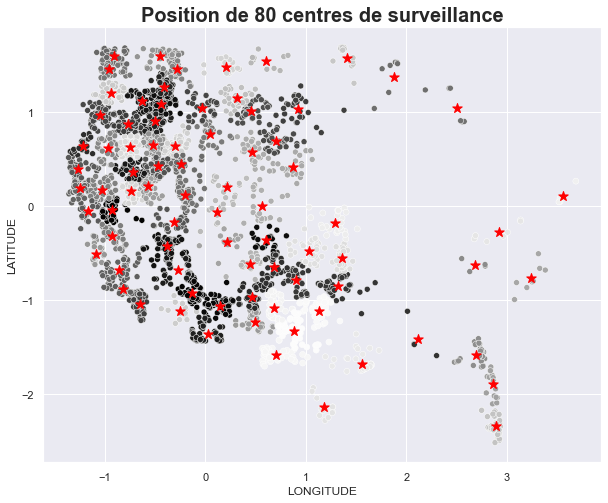

In [76]:
# Pour créer la colonne des clusters dans le dataframe 
df_fires_model_g_kmeans_norm_80['cluster']=y_kmeans_80

centroids_80 = kmeans_80.cluster_centers_

plt.figure(figsize=(10,8))
sns.scatterplot(x=df_fires_model_g_kmeans_norm_80.LONGITUDE,y=df_fires_model_g_kmeans_norm_80.LATITUDE,palette='gray',hue=df_fires_model_g_kmeans_norm_80.cluster.astype('str'),legend=False)
plt.scatter(centroids_80[:, 0],centroids_80[:, 1], s=100, c='red', label='Centroids', marker='*')
plt.title('Position de 80 centres de surveillance', fontweight='bold', fontsize=20)
plt.show()

### 100 centres de surveillance

In [77]:
# Création de l'instance KMeans
kmeans_100 = KMeans(n_clusters=100)

# Ajustement 
kmeans_100.fit(fires_model_g_kmeans_norm)

# Prédictions
y_kmeans_100 = kmeans_100.predict(fires_model_g_kmeans_norm)

df_fires_model_g_kmeans_norm_100 = pd.DataFrame(fires_model_g_kmeans_norm, columns=['LONGITUDE','LATITUDE'])

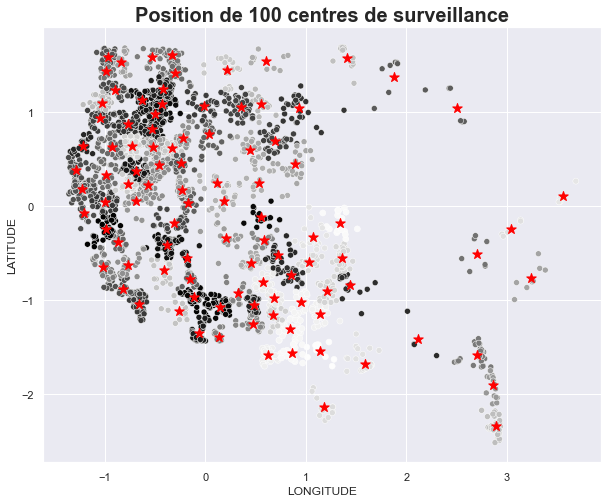

In [ ]:
# Pour créer la colonne des clusters dans le dataframe 
df_fires_model_g_kmeans_norm_100['cluster']=y_kmeans_100

centroids_100 = kmeans_100.cluster_centers_

plt.figure(figsize=(10,8))
sns.scatterplot(x=df_fires_model_g_kmeans_norm_100.LONGITUDE,y=df_fires_model_g_kmeans_norm_100.LATITUDE,palette='gray',hue=df_fires_model_g_kmeans_norm_100.cluster.astype('str'),legend=False)
plt.scatter(centroids_100[:, 0],centroids_100[:, 1], s=100, c='red', label='Centroids', marker='*')
plt.title('Position de 100 centres de surveillance', fontweight='bold', fontsize=20)
plt.show()